In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [3]:
import pyspark
sc = pyspark.SparkContext(appName="FraudDetection")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 16:49:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("FraudDetection") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()
spark

In [5]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg, stddev, count, hour, col, max
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
from pyspark.sql import functions as F


warnings.filterwarnings("ignore")
data_path='/kaggle/input/transactions-data-big-data/Transactions Data/Transactions Data'

In [6]:
# Load the users data
users_df = spark.read.csv(f"{data_path}/users.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the columns to double type
users_df = users_df.withColumn("per_capita_income", F.regexp_replace("per_capita_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("yearly_income", F.regexp_replace("yearly_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("total_debt", F.regexp_replace("total_debt", "[\$,]", "").cast("double"))

print(users_df.count())
# Check the count of rows
users_df.show(3)

1219
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|client_id|current_age|retirement_age|birth_year|birth_month|gender|            address|latitude|longitude|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|     1645|         62|            65|      1957|         11|Female|    58 Federal Lane|   41.47|   -81.85|          29692.0|      60541.0|  160456.0|         716|               3|
|     1591|         58|            66|      1961|          6|Female|   2200 Third Drive|   48.28|  -122.62|          16537.0|      33717.0|   58236.0|         698|               6|
|     1959|         46|            59|      1973|          4|  Male|8750 Lake Boulevard|  

In [7]:
# Read the transactions data
transactions_df = spark.read.csv(f"{data_path}/transactions.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'amount' column to double type
transactions_df = transactions_df.withColumn("amount", F.regexp_replace("amount", "[\$,]", "").cast("double"))

# Check the count of rows
print(transactions_df.count())
transactions_df.show(3)

8914963


+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|     id|               date|client_id|card_id|amount|         use_chip|merchant_id|  merchant_city| mcc|  errors|target|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|7475341|2010-01-01 00:27:00|     1797|   1127| 43.33|Swipe Transaction|      33326|        Kahului|4121|No Error|    No|
|7475347|2010-01-01 00:36:00|      114|   3398| -64.0|Swipe Transaction|      61195|North Hollywood|5541|No Error|    No|
|7475378|2010-01-01 01:19:00|     1575|   2112| 17.14|Swipe Transaction|      29232|         Osprey|4121|No Error|    No|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
only showing top 3 rows



In [8]:
# Read the cards data
cards_df = spark.read.csv(f"{data_path}/cards.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'credit_limit' column to double type
cards_df = cards_df.withColumn("credit_limit", F.regexp_replace("credit_limit", "[\$,]", "").cast("double"))

# Check the count of rows
print(cards_df.count())
cards_df.show(3)

4514
+---------+-------+----------+---------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+----------------+
|client_id|card_id|card_brand|card_type|     card_number|expires|cvv|has_chip|num_cards_issued|credit_limit|acct_open_date|year_pin_last_changed|card_on_dark_web|
+---------+-------+----------+---------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+----------------+
|      825|   4524|      Visa|    Debit|4344676511950444|12/2022|623|     YES|               2|     24295.0|       09/2002|                 2008|              No|
|      825|   2731|      Visa|    Debit|4956965974959986|12/2020|393|     YES|               2|     21968.0|       04/2014|                 2014|              No|
|      825|   3701|      Visa|    Debit|4582313478255491|02/2024|719|     YES|               2|     46414.0|       07/2003|                 2004|              No|
+---------+------

In [9]:
# Calculate spending per user
user_spending = transactions_df.groupBy("client_id").agg(
    F.count("*").alias("num_transactions"),
    F.avg("amount").alias("avg_transaction_amount"),
    F.sum("amount").alias("total_spent"),
    F.stddev("amount").alias("std_transaction_amount")
)
user_spending.show(3)

+---------+----------------+----------------------+------------------+----------------------+
|client_id|num_transactions|avg_transaction_amount|       total_spent|std_transaction_amount|
+---------+----------------+----------------------+------------------+----------------------+
|     1959|            3451|      86.3550449145175| 298011.2599999999|     163.6705151652383|
|      148|            7426|    35.218777269054684| 261534.6400000001|    57.421591677235426|
|     1591|           14659|     28.58476908383927|419024.12999999983|     58.41412838493421|
+---------+----------------+----------------------+------------------+----------------------+
only showing top 3 rows



In [10]:
# Merge user and card features
cards_summary = cards_df.groupBy("client_id").agg(
    F.avg("credit_limit").alias("avg_credit_limit"),
    F.sum("credit_limit").alias("total_credit_limit"),
)
cards_summary.show(3)

+---------+------------------+------------------+
|client_id|  avg_credit_limit|total_credit_limit|
+---------+------------------+------------------+
|     1645|17949.666666666668|           53849.0|
|     1591|           10753.5|           64521.0|
|     1959|           11100.0|           11100.0|
+---------+------------------+------------------+
only showing top 3 rows



In [11]:
# Merge all features
features_df = users_df.join(user_spending, on="client_id", how="inner") \
                      .join(cards_summary, on="client_id", how="inner")

# Drop unused or high-cardinality columns
drop_cols = ["address", "birth_month", "birth_year","client_id","latitude","longitude","gender","any_card_on_dark_web","retirement_age","current_age"]
features_df = features_df.drop(*drop_cols)

features_df.show(1)

+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------------+----------------------+----------------+------------------+
|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|num_transactions|avg_transaction_amount|      total_spent|std_transaction_amount|avg_credit_limit|total_credit_limit|
+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------------+----------------------+----------------+------------------+
|          25565.0|      52130.0|   80367.0|         701|               1|            3451|      86.3550449145175|298011.2599999999|     163.6705151652383|         11100.0|           11100.0|
+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------------+----------------------+----------------+------------------+
only showing top 1 row



In [12]:
# Assemble and scale features first
assembler = VectorAssembler(inputCols=features_df.columns, outputCol="unscaled_features")
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

assembled_scaled = Pipeline(stages=[assembler, scaler]).fit(features_df).transform(features_df)

# Elbow and silhouette_score methods 
cost = []
scores = []
for k in range(2, 10):
    kmeans = KMeans(k=k, seed=42, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(assembled_scaled)
    transformed = model.transform(assembled_scaled)
    pandas_df = transformed.select("features", "cluster").toPandas()
    features = pandas_df["features"].apply(lambda x: x.toArray()).tolist()
    labels = pandas_df["cluster"]
    score = silhouette_score(features, labels)
    scores.append(score)
    cost.append(model.summary.trainingCost)

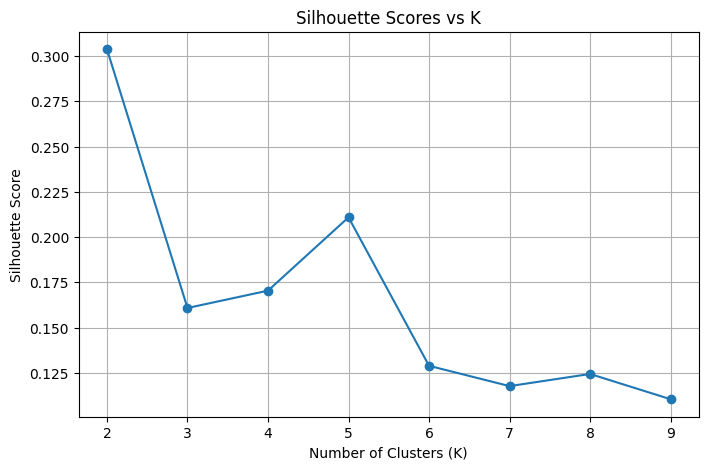

In [13]:
plt.figure(figsize=(8,5))
plt.plot(range(2, 10), scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores vs K")
plt.grid(True)
plt.show()

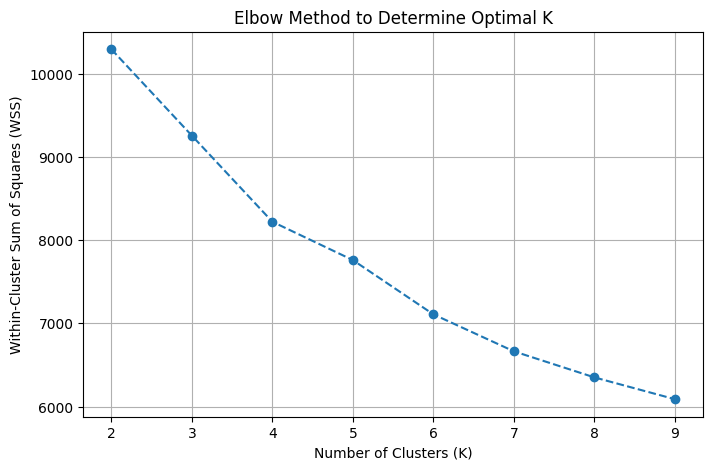

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), cost, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method to Determine Optimal K")
plt.xticks(range(2, 10))  # Force x-axis to show integer values
plt.grid(True)
plt.show()

In [15]:
# optimal number found from the elbow graph
best_k = 5


kmeans = KMeans(k=best_k, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(assembled_scaled)
clustered_df = model.transform(assembled_scaled)

clustered_df.groupBy("cluster").agg(
    F.count("*").alias("num_users"),
    F.avg("yearly_income").alias("avg_income"),
    F.avg("total_spent").alias("avg_spending"),
    F.avg("credit_score").alias("avg_credit_score")
).orderBy("cluster").show()

+-------+---------+------------------+------------------+-----------------+
|cluster|num_users|        avg_income|      avg_spending| avg_credit_score|
+-------+---------+------------------+------------------+-----------------+
|      0|      168| 70411.20238095238| 408723.0073809524|            683.5|
|      1|      174|44031.362068965514| 575318.5426436784|710.9310344827586|
|      2|      691| 34569.89435600579|206705.52793053543|713.7380607814761|
|      3|      178|56268.550561797754| 371812.1718539327| 741.814606741573|
|      4|        8|        200580.125|      638152.43625|          705.875|
+-------+---------+------------------+------------------+-----------------+



In [16]:
centers = model.clusterCenters()
centers_df = pd.DataFrame(centers, columns=features_df.columns)

# Compute standard deviation of feature values across clusters
feature_importance = centers_df.std().sort_values(ascending=False)
# Show top 3 features
top_features = feature_importance.head(5)
print("Top contributing features to cluster separation:")
print(top_features)

Top contributing features to cluster separation:
per_capita_income         3.048570
yearly_income             2.923876
avg_credit_limit          2.675633
total_credit_limit        2.472110
std_transaction_amount    1.683288
dtype: float64


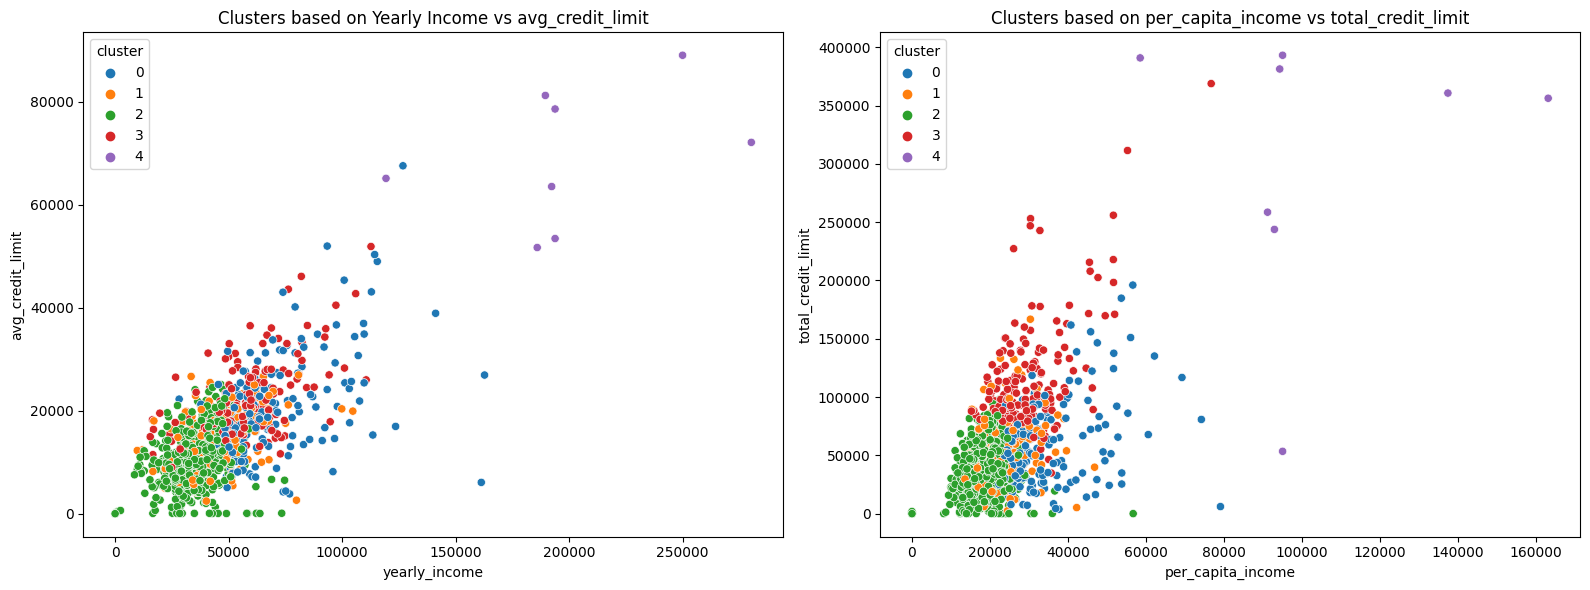

In [17]:
plot_df = clustered_df.select(*features_df.columns, "cluster").toPandas()
# Create a 1x2 grid of subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Example 1: yearly_income vs avg_credit_limit
sns.scatterplot(data=plot_df, x="yearly_income", y="avg_credit_limit", hue="cluster", palette="tab10", ax=axes[0])
axes[0].set_title("Clusters based on Yearly Income vs avg_credit_limit")

# Example 2: per_capita_income vs total_credit_limit
sns.scatterplot(data=plot_df, x="per_capita_income", y="total_credit_limit", hue="cluster", palette="tab10", ax=axes[1])
axes[1].set_title("Clusters based on per_capita_income vs total_credit_limit")

# Display the plot
plt.tight_layout()
plt.show()

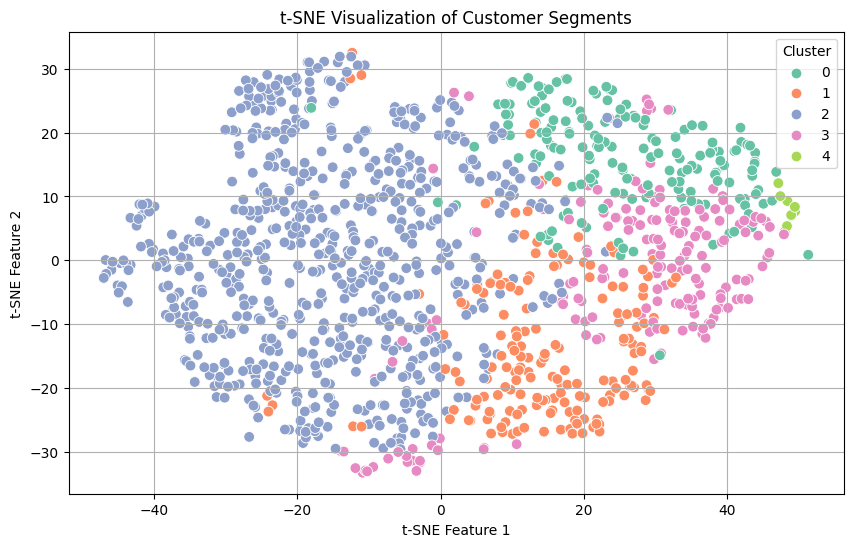

In [18]:
clustered_pandas = clustered_df.select("features", "cluster").toPandas()


X = np.array([np.array(vec.toArray()) for vec in clustered_pandas["features"]])
y = clustered_pandas["cluster"]

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)


# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2', s=60)
plt.title("t-SNE Visualization of Customer Segments")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [19]:
# Drop unused or high-cardinality columns
drop_cols = ["address", "birth_month", "birth_year","client_id","latitude","longitude","gender","any_card_on_dark_web","retirement_age","current_age","avg_credit_limit","avg_transaction_amount","std_transaction_amount"]

features_df = features_df.drop(*drop_cols)


In [20]:
assembler = VectorAssembler(inputCols=features_df.columns, outputCol="features")


# Transform data to get 'features' column
assembled_df = assembler.transform(features_df)

# Rename the 'label' column (target for regression)
assembled_df = assembled_df.withColumnRenamed("credit_score", "label")

#  Split into training and test sets (80% train, 20% test)
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)


In [21]:
lr = LinearRegression(featuresCol="features", labelCol="label",regParam=0.1)
lr_model = lr.fit(train_df)

In [22]:
training_summary = lr_model.summary

print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
print("RMSE:", training_summary.rootMeanSquaredError)
print("R2:", training_summary.r2)

Coefficients: [-2.781460306018969e-06,1.2480481901155826e-06,-1.9402580837578853e-07,0.9983583445878259,0.012355133539712139,9.805427967451177e-07,-4.498377853308138e-08,2.9199431348752213e-07]
Intercept: 1.1324620286788911
RMSE: 0.10399429557263258
R2: 0.9999975180962967


In [23]:
# Predict
predictions = lr_model.transform(test_df).select("label", "prediction")

# Convert to Pandas for plotting
residuals_pd = predictions.toPandas()
residuals_pd["residual"] = residuals_pd["label"] - residuals_pd["prediction"]

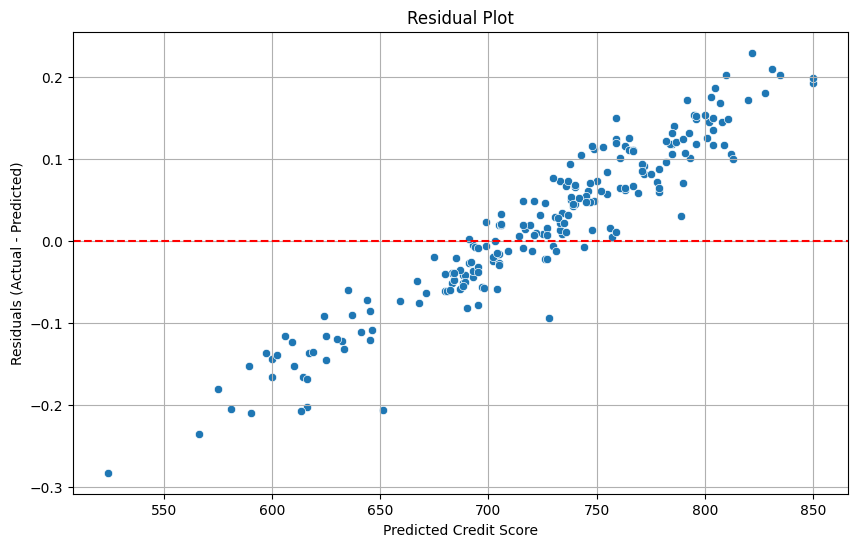

In [24]:
# Plot 1: Residuals Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=residuals_pd["prediction"], y=residuals_pd["residual"])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Credit Score")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

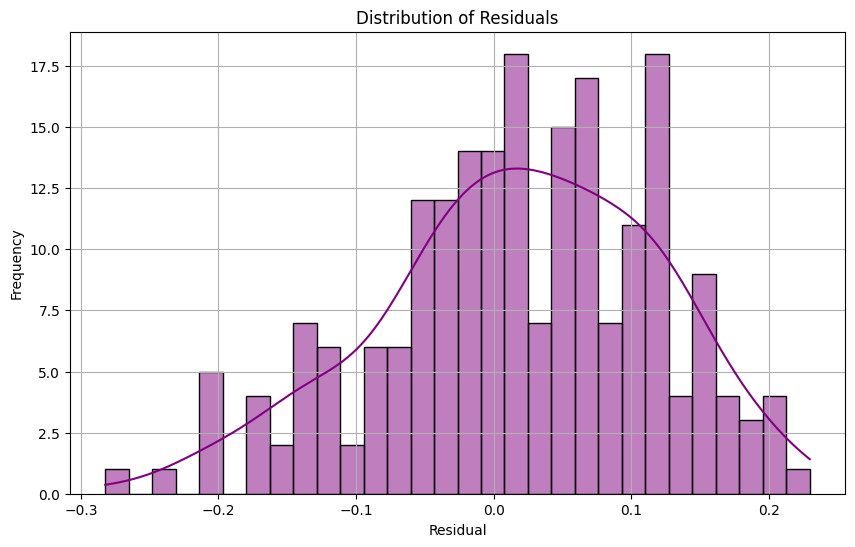

In [25]:
# Plot 2: Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_pd["residual"], kde=True, bins=30, color='purple')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()